In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow_probability import distributions as tfd

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
from general_utilis import * # generate_dataset, visualise_data_points

In [5]:
# basic model, WTA, RWTA, disconected WTA
from models.encoders.resnet_18 import resnet_18
from models.heads.basic import * #basic_localisation_model, basic_localisation_model_disconected_graph
from models.decoders.fpn import resnet_fpn
from losses.mean_squared_error import *

In [6]:
# MDN model
from losses.mdn_loss import *  # mdn_loss
from losses.mdn_rwta import *  # get_RWTA_loss
from losses.x_entropy_rwta import *  # get_CE_RWTA_loss
from models.heads.mdn import mdn_model
from models.utilis.callbacks import *  # GMM_Metrics, trace_max_component
from visualisations import *
from evaluate_utilis import *  # evaluate_GMM_log_likelihood

In [63]:
# Callbacks as metric for model comparison while training
from models.callbacks import *  # model_log_likelihood_callback

# Generate Dataset

In [14]:
dataset_size = 1000
num_modes = 3
output_dim = 1
num_patterns = 10
noise = 0

images, labels, modes, pattern_ids = generate_dataset(dataset_size, num_modes, output_dim, num_patterns, noise)

## Visualise dataset - to check that evertyhing is correct

same pattern, different modes


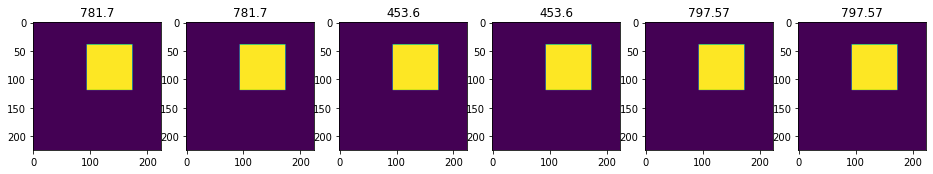

same pattern, same modes


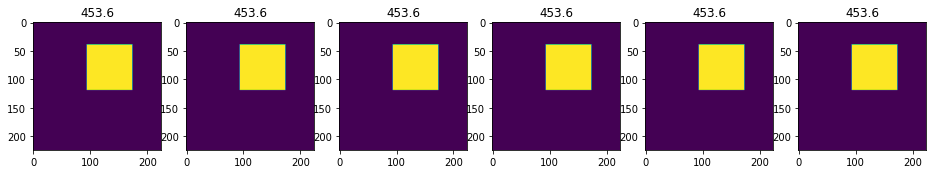

In [15]:
visualise_data_points(images, labels, modes, pattern_ids)

# Train, test split

In [16]:
train_size = 0.7
split = int(dataset_size * train_size)
x_train, x_test = images[:split], images[split:]
y_train, y_test = labels[:split], labels[split:]

In [17]:
modes_train, modes_test = modes[:split], modes[split:] 
pattern_ids_train, pattern_ids_test = pattern_ids[:split], pattern_ids[split:]

# Construct simple encoder-decoder network

### Encoder network

In [270]:
# get model
num_heads = 1
model = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer=adam, loss=multiple_heads_MSE(num_heads))

In [273]:
# fit with MSE
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
22/22 [==============================] - 1s 43ms/step - loss: 942.4219
Epoch 2/10
22/22 [==============================] - 1s 42ms/step - loss: 778.7093
Epoch 3/10
22/22 [==============================] - 1s 41ms/step - loss: 773.7058
Epoch 4/10
22/22 [==============================] - 1s 42ms/step - loss: 451.1288
Epoch 5/10
22/22 [==============================] - 1s 42ms/step - loss: 520.4225
Epoch 6/10
22/22 [==============================] - 1s 43ms/step - loss: 411.5976
Epoch 7/10
22/22 [==============================] - 1s 41ms/step - loss: 629.0049
Epoch 8/10
22/22 [==============================] - 1s 41ms/step - loss: 256.2217
Epoch 9/10
22/22 [==============================] - 1s 42ms/step - loss: 215.8119
Epoch 10/10
22/22 [==============================] - 1s 42ms/step - loss: 194.1711


### Visualise predictions

In [10]:
np.set_printoptions(suppress=True)

# visualise predictions
def print_predictions(model, x, y, num_heads):
    y_pred = model.predict(x)
    for gt, pred in zip(y, y_pred):
        min_error = 1e9
        for i in range(num_heads):
            min_error = min(min_error, np.round(np.mean(np.abs(gt-pred[i*3:(i+1)*3])),1))
        print('GT: ', np.round(gt,1), '   Pred: ', np.round(pred,1), '   Error: ', min_error)
        
# print_predictions(model, x_test[:10], y_test[:10], num_heads=1)

### Visualise performance on different modes for a single class

In [11]:
def print_error_per_mode(model, x, y, pattern_ids, modes, pattern_ID, num_modes, num_heads):
    pattern_indexes = np.where(pattern_ids == pattern_ID, 1, 0)
    
    for i in range(num_modes):
        mode_indexes = np.where(modes == i, 1, 0)
        mode_pat_indexes = pattern_indexes*mode_indexes
        mode_pat_indexes = mode_pat_indexes.astype(bool)

        x_tmp = x[mode_pat_indexes]
        y_tmp = y[mode_pat_indexes]
        y_pred = model.predict(x_tmp)
        
        print()
        for j in range(num_heads):
            mean_error = np.mean(np.abs(y_pred[:,j*3:(j+1)*3] - y_tmp))
            print(f'Head {j}, Mode {i} mean error: {np.round(mean_error, 2)}')
        print_predictions(model, x_tmp[:5], y_tmp[:5], num_heads)

# print_error_per_mode(model, x_test, y_test, pattern_ids_test, modes_test, 0, num_modes, num_heads=1)

<font color='red'>**I had to remove noise - but now atleast we clearly see that the NN learns to represent only one solution**</font>

# Train basic model - 3 MSE heads

In [120]:
# get model
num_heads = 3
model_3_heads = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model_3_heads.compile(optimizer=adam, loss=multiple_heads_MSE(num_heads))

In [121]:
# fit with MSE
model_3_heads.fit(x_train, y_train, batch_size=32, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 51ms/step - loss: 111364.2734
Epoch 2/40
22/22 [==============================] - 1s 48ms/step - loss: 101474.5000
Epoch 3/40
22/22 [==============================] - 1s 48ms/step - loss: 86211.9766
Epoch 4/40
22/22 [==============================] - 1s 50ms/step - loss: 67118.6016
Epoch 5/40
22/22 [==============================] - 1s 49ms/step - loss: 47357.3359
Epoch 6/40
22/22 [==============================] - 1s 51ms/step - loss: 30688.4551
Epoch 7/40
22/22 [==============================] - 1s 48ms/step - loss: 20355.7949
Epoch 8/40
22/22 [==============================] - 1s 46ms/step - loss: 15673.2461
Epoch 9/40
22/22 [==============================] - 1s 46ms/step - loss: 14694.9453
Epoch 10/40
22/22 [==============================] - 1s 49ms/step - loss: 14525.5469
Epoch 11/40
22/22 [==============================] - 1s 49ms/step - loss: 14669.3389
Epoch 12/40
22/22 [==============================] - 1s 53ms/step - loss

In [132]:
print_error_per_mode(model_3_heads, x_test, y_test, pattern_ids_test, modes_test, 3, num_modes, num_heads)


Head 0, Mode 0 mean error: 18.02
Head 1, Mode 0 mean error: 17.87
Head 2, Mode 0 mean error: 17.96
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9
GT:  [217.6   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  17.9

Head 0, Mode 1 mean error: 15.13
Head 1, Mode 1 mean error: 14.98
Head 2, Mode 1 mean error: 15.08
GT:  [226.3   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  15.0
GT:  [226.3   0.    0. ]    Pred:  [271.3  -0.1   0.2 271.    0.    0.2 271.4   0.1  -0. ]    Error:  15.0
GT:  [226.3   0.    0. ]    Pred:  [271.3  -0.1   0

<font color='red'>**As expected all 3 heads colapse to the same solution**</font>

# Train basic model - WTA loss function

In [150]:
# get model
num_heads = 3
model_3_heads_WTA = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model_3_heads_WTA.compile(optimizer=adam, loss=multiple_heads_MSE_WTA(num_heads))

In [151]:
# fit with MSE
model_3_heads_WTA.fit(x_train, y_train, batch_size=32, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 60ms/step - loss: 36953.0898
Epoch 2/40
22/22 [==============================] - 1s 52ms/step - loss: 32951.7383
Epoch 3/40
22/22 [==============================] - 1s 58ms/step - loss: 26322.8828
Epoch 4/40
22/22 [==============================] - 1s 53ms/step - loss: 18376.6875
Epoch 5/40
22/22 [==============================] - 1s 55ms/step - loss: 11272.0029
Epoch 6/40
22/22 [==============================] - 1s 53ms/step - loss: 6660.7720
Epoch 7/40
22/22 [==============================] - 1s 50ms/step - loss: 5066.5312
Epoch 8/40
22/22 [==============================] - 1s 49ms/step - loss: 4825.9741
Epoch 9/40
22/22 [==============================] - 1s 48ms/step - loss: 4887.4448
Epoch 10/40
22/22 [==============================] - 1s 44ms/step - loss: 5174.6631
Epoch 11/40
22/22 [==============================] - 1s 46ms/step - loss: 4951.6509
Epoch 12/40
22/22 [==============================] - 1s 45ms/step - loss: 4947.2

In [153]:
print_error_per_mode(model_3_heads_WTA, x_test, y_test, pattern_ids_test, modes_test, 3, num_modes, num_heads)


Head 0, Mode 0 mean error: 26.49
Head 1, Mode 0 mean error: 73.22
Head 2, Mode 0 mean error: 72.9
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5
GT:  [217.6   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  26.5

Head 0, Mode 1 mean error: 23.6
Head 1, Mode 1 mean error: 76.11
Head 2, Mode 1 mean error: 75.79
GT:  [226.3   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  23.6
GT:  [226.3   0.    0. ]    Pred:  [296.8  -0.1  -0.1  -0.2  -1.4   0.4  -0.2  -0.3  -0.6]    Error:  23.6
GT:  [226.3   0.    0. ]    Pred:  [296.8  -0.1  -0.1

<font color='red'>**Above we have an example of WTA problem**</font> Due to poor initalisation only one head gets updated at each batch itteration, because it has always the lowest error

# Train basic model - Relaxed-WTA loss function

https://arxiv.org/abs/1612.00197 - Learning in an Uncertain World: Representing Ambiguity Through Multiple Hypotheses

In [24]:
# get model
num_heads = 3
relaxation_weight = 0.001
model_3_heads_R_WTA = basic_localisation_model(resnet_18, num_heads, input_shape=(224,224,1))    

In [36]:
# compile
adam = keras.optimizers.Adam(0.0001)
model_3_heads_R_WTA.compile(optimizer=adam, loss=multiple_heads_MSE_Relaxed_WTA(num_heads, relaxation_weight))

In [37]:
# fit with MSE
model_3_heads_R_WTA.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
22/22 [==============================] - 1s 47ms/step - loss: 15310.1260
Epoch 2/10
22/22 [==============================] - 1s 44ms/step - loss: 15215.0010
Epoch 3/10
22/22 [==============================] - 1s 44ms/step - loss: 15420.9990
Epoch 4/10
22/22 [==============================] - 1s 45ms/step - loss: 15263.9141
Epoch 5/10
22/22 [==============================] - 1s 48ms/step - loss: 15378.4219: 0s - loss: 1
Epoch 6/10
22/22 [==============================] - 1s 46ms/step - loss: 15367.7139
Epoch 7/10
22/22 [==============================] - 1s 44ms/step - loss: 15560.7725
Epoch 8/10
22/22 [==============================] - 1s 45ms/step - loss: 15515.4600
Epoch 9/10
22/22 [==============================] - 1s 47ms/step - loss: 15201.9941
Epoch 10/10
22/22 [==============================] - 1s 46ms/step - loss: 15545.5645


In [35]:
print_error_per_mode(model_3_heads_R_WTA, x_test, y_test, pattern_ids_test, modes_test, 1, num_modes, num_heads)


Head 0, Mode 0 mean error: 99.68
Head 1, Mode 0 mean error: 119.86
Head 2, Mode 0 mean error: 77.73
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7
GT:  [379.3   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  77.7

Head 0, Mode 1 mean error: 43.87
Head 1, Mode 1 mean error: 23.56
Head 2, Mode 1 mean error: 65.62
GT:  [809.2   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  23.6
GT:  [809.2   0.    0. ]    Pred:  [677.9  -0.3   0.  738.7   0.1  -0.1 612.4   0.1   0. ]    Error:  23.6
GT:  [809.2   0.    0. ]    Pred:  [677.9  -0.3   

<font color='red'>**Heads do not colapse**</font> However, they don't cover each mode exactly. Heads' predictions lie somewhere in between modes. - not sure why this is the case. <font color='red'>**I may explore that case in more detail.**</font>

Things to try:
* see if your idea of disconecting gradients from seperate heads will work. i.e to make the main head learn the features of the trunk.

# Train basic model - disconected RWTA

In [183]:
# get model
num_heads = 3
relaxation_weight = 0.01
model_3_heads_RWTA_and_disconected = basic_localisation_model_disconected_graph(resnet_18, num_heads, input_shape=(224,224,1))    

# compile
adam = keras.optimizers.Adam(0.001)
model_3_heads_RWTA_and_disconected.compile(optimizer=adam, loss=multiple_heads_MSE_Relaxed_WTA(num_heads, relaxation_weight))

In [184]:
# fit with MSE
model_3_heads_R_WTA.fit(x_train, y_train, batch_size=32, epochs=40)

Epoch 1/40
22/22 [==============================] - 1s 56ms/step - loss: 98410.6875
Epoch 2/40
22/22 [==============================] - 1s 56ms/step - loss: 89509.9453
Epoch 3/40
22/22 [==============================] - 1s 56ms/step - loss: 75127.7578: 1s - lo
Epoch 4/40
22/22 [==============================] - 1s 55ms/step - loss: 57383.6797
Epoch 5/40
22/22 [==============================] - 1s 49ms/step - loss: 39085.6758
Epoch 6/40
22/22 [==============================] - 1s 52ms/step - loss: 25048.3457
Epoch 7/40
22/22 [==============================] - 1s 51ms/step - loss: 16880.5527
Epoch 8/40
22/22 [==============================] - 1s 53ms/step - loss: 18644.9453
Epoch 9/40
22/22 [==============================] - 1s 51ms/step - loss: 17151.6016
Epoch 10/40
22/22 [==============================] - 1s 51ms/step - loss: 19208.7402
Epoch 11/40
22/22 [==============================] - 1s 57ms/step - loss: 18317.2422
Epoch 12/40
22/22 [==============================] - 1s 53ms/step

In [185]:
print_error_per_mode(model_3_heads_R_WTA, x_test, y_test, pattern_ids_test, modes_test, 1, num_modes, num_heads)


Head 0, Mode 0 mean error: 41.35
Head 1, Mode 0 mean error: 1.38
Head 2, Mode 0 mean error: 28.01
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4
GT:  [618.3   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  1.4

Head 0, Mode 1 mean error: 37.15
Head 1, Mode 1 mean error: 3.08
Head 2, Mode 1 mean error: 23.81
GT:  [605.7   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  3.1
GT:  [605.7   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6  -0.3   0.1 534.9   0.3   0.2]    Error:  3.1
GT:  [605.7   0.    0. ]    Pred:  [494.7   0.2  -0.3 614.6 

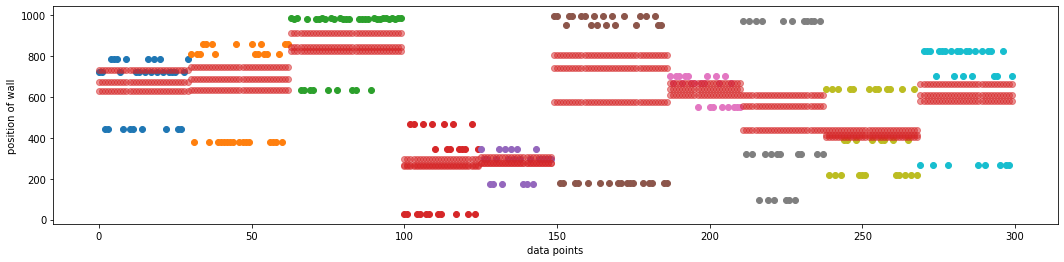

In [65]:
visualise_mode_overlap(model_3_heads_R_WTA, x_test, y_test, pattern_ids_test)

**above shows how predicted modes overlap with actual modes**, we see that they don't overlap that well.
RED are predicted modes

# MDN - for 2D problem - 3 modes 3 mixtures

In [11]:
# get model
num_comp = 6
output_shape = 1
model_MDN = mdn_model(resnet_18, num_comp=num_comp, output_shape=output_shape, input_shape=(224,224,1))    

In [16]:
# compile
adam = keras.optimizers.Adam(0.0001)
model_MDN.compile(optimizer=adam, 
                  loss=mdn_loss(num_comp, output_shape=output_shape, fixed_variance=True), 
                  metrics=trace_max_component(num_comp, 10))

In [17]:
# train the model
# history = model_MDN.fit(x_train, y_train, batch_size=32, epochs=200)
history_var_on = model_MDN.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
tfp.distributions.Categorical("get_mdn_loss_Categorical", batch_shape=[?], event_shape=[], dtype=int32)
tfp.distributions.Categorical("get_mdn_loss_Categorical", batch_shape=[?], event_shape=[], dtype=int32)
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 2/22 [=>............................] - ETA: 0s - loss: 133357.6719 - max_mixture: 0.8632<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 5/22 [=====>........................] - ETA: 0s - loss: 124661.9531 - max_mixture: 0.8144<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
11/22 [==============>...............] - ETA: 0s - loss: 122058.4766 - max_mixture: 0.8095<

<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 5/22 [=====>........................] - ETA: 0s - loss: 125215.0000 - max_mixture: 0.8975<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
11/22 [==============>...............] - ETA: 0s - loss: 118961.5469 - max_mixture: 0.8866<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
13/22 [================>.............] - ETA: 0s - loss: 119595.0469 - max_mixture: 0.8870<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
15/22 [=========

12/22 [===============>..............] - ETA: 0s - loss: 116900.1875 - max_mixture: 0.9240<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
19/22 [========================>.....] - ETA: 0s - loss: 120652.1172 - max_mixture: 0.9218<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
22/22 [==============================] - 1s 52ms/step - loss: 115987.6719 - max_mixture: 0.9224
Epoch 6/10
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 1/22 [>.............................] - ETA: 0s - loss: 137375.8594 - max_mixture: 0.9294<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distri

22/22 [==============================] - 1s 54ms/step - loss: 114791.2266 - max_mixture: 0.9282
Epoch 10/10
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 3/22 [===>..........................] - ETA: 0s - loss: 117895.0234 - max_mixture: 0.9429<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 5/22 [=====>........................] - ETA: 0s - loss: 113999.8750 - max_mixture: 0.9376<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
 7/22 [========>.....................] - ETA: 0s - loss: 112987.8359 - max_mixture: 0.9381<tfp.distributions.Categorical 'get_mdn_loss_Categorical' batch_shape=[?] event_shape=[] dtype=int32>
<tfp.distr

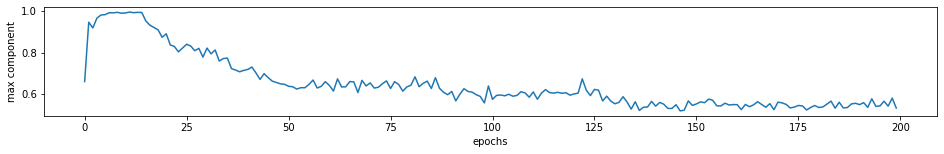

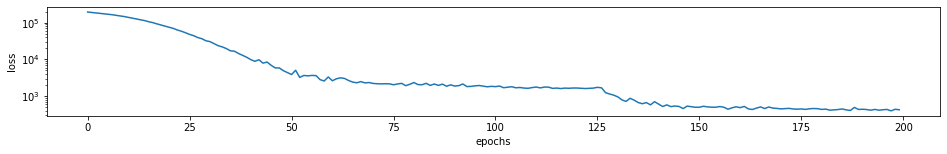

In [207]:
visualise_model_evolution(history.history['max_mixture'], 'max component')
visualise_model_evolution(history.history['loss'], 'loss', log=True)

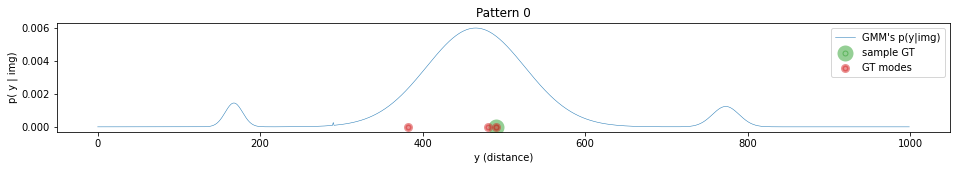

GT: [490.4910383]
Component 1: pi= 0.05 , mu= 773.1 , sig= 16.41
Component 2: pi= 0.04 , mu= 167.68 , sig= 10.78
Component 3: pi= 0.0 , mu= 375.29 , sig= 0.13
Component 4: pi= 0.0 , mu= 289.88 , sig= 0.19
Component 5: pi= 0.91 , mu= 465.24 , sig= 60.54
Component 6: pi= 0.0 , mu= 66.42 , sig= 213.17


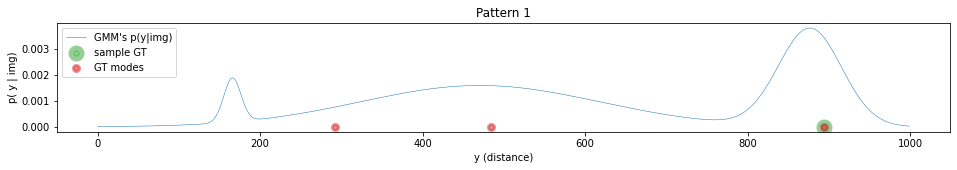

GT: [894.18601299]
Component 1: pi= 0.37 , mu= 876.67 , sig= 38.82
Component 2: pi= 0.04 , mu= 165.83 , sig= 10.54
Component 3: pi= 0.0 , mu= 396.87 , sig= 0.34
Component 4: pi= 0.0 , mu= 271.75 , sig= 0.01
Component 5: pi= 0.59 , mu= 470.39 , sig= 146.91
Component 6: pi= 0.0 , mu= 68.59 , sig= 109.0


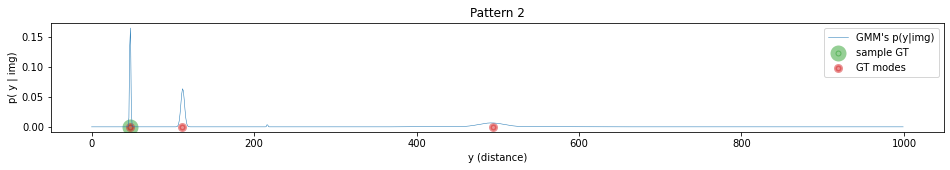

GT: [47.59360604]
Component 1: pi= 0.25 , mu= 492.17 , sig= 15.56
Component 2: pi= 0.36 , mu= 112.22 , sig= 2.23
Component 3: pi= 0.01 , mu= 216.4 , sig= 0.64
Component 4: pi= 0.03 , mu= 558.76 , sig= 41.26
Component 5: pi= 0.02 , mu= 417.65 , sig= 19.28
Component 6: pi= 0.34 , mu= 47.6 , sig= 0.71


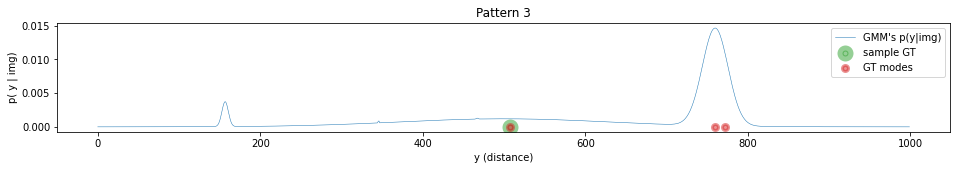

GT: [507.35128298]
Component 1: pi= 0.57 , mu= 759.89 , sig= 15.78
Component 2: pi= 0.04 , mu= 156.75 , sig= 3.95
Component 3: pi= 0.0 , mu= 345.59 , sig= 0.44
Component 4: pi= 0.0 , mu= 467.06 , sig= 1.17
Component 5: pi= 0.39 , mu= 500.07 , sig= 130.15
Component 6: pi= 0.0 , mu= 60.67 , sig= 12.26


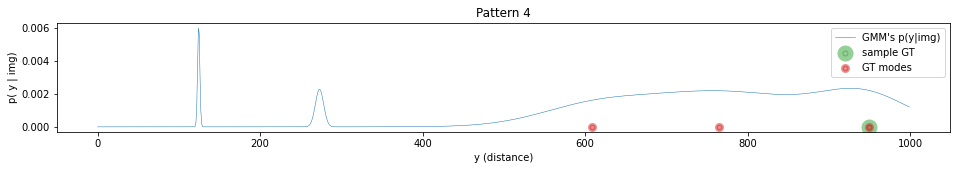

GT: [949.6829022]
Component 1: pi= 0.61 , mu= 764.75 , sig= 112.48
Component 2: pi= 0.02 , mu= 124.39 , sig= 1.36
Component 3: pi= 0.03 , mu= 273.08 , sig= 5.07
Component 4: pi= 0.22 , mu= 943.92 , sig= 52.8
Component 5: pi= 0.13 , mu= 603.24 , sig= 63.07
Component 6: pi= 0.0 , mu= 52.84 , sig= 0.01


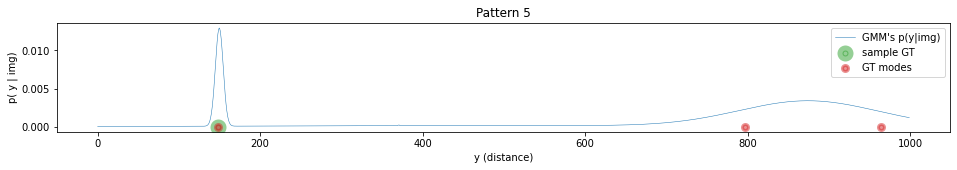

GT: [148.19040314]
Component 1: pi= 0.71 , mu= 874.82 , sig= 85.37
Component 2: pi= 0.16 , mu= 149.71 , sig= 4.82
Component 3: pi= 0.0 , mu= 370.66 , sig= 0.77
Component 4: pi= 0.0 , mu= 434.29 , sig= 0.07
Component 5: pi= 0.13 , mu= 503.71 , sig= 309.0
Component 6: pi= 0.0 , mu= 62.27 , sig= 8.81


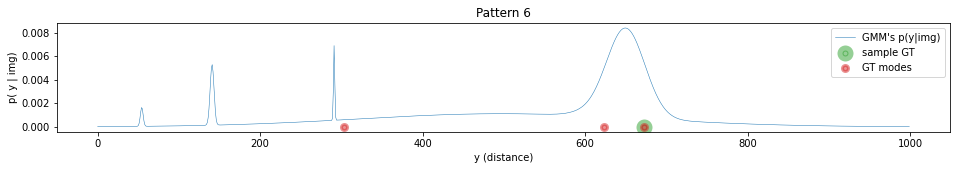

GT: [672.10076232]
Component 1: pi= 0.45 , mu= 649.73 , sig= 23.7
Component 2: pi= 0.03 , mu= 140.81 , sig= 2.36
Component 3: pi= 0.01 , mu= 291.07 , sig= 0.76
Component 4: pi= 0.01 , mu= 594.02 , sig= 16.98
Component 5: pi= 0.49 , mu= 496.91 , sig= 174.96
Component 6: pi= 0.01 , mu= 54.28 , sig= 1.7


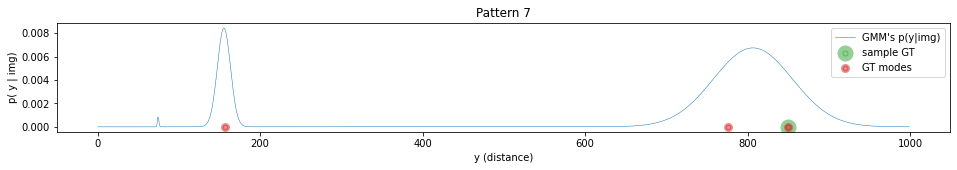

GT: [849.15310719]
Component 1: pi= 0.01 , mu= 533.62 , sig= 240.6
Component 2: pi= 0.0 , mu= 74.43 , sig= 0.84
Component 3: pi= 0.17 , mu= 155.41 , sig= 8.06
Component 4: pi= 0.82 , mu= 806.54 , sig= 48.6
Component 5: pi= 0.0 , mu= 448.51 , sig= 9.89
Component 6: pi= 0.0 , mu= 37.09 , sig= 0.01


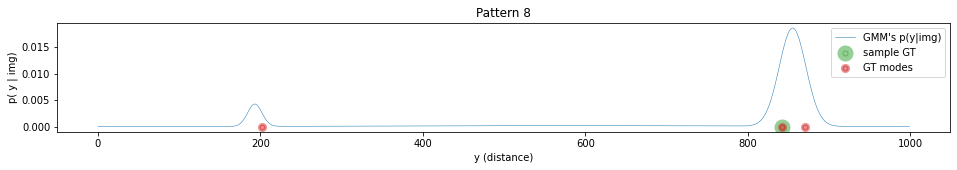

GT: [842.36722004]
Component 1: pi= 0.76 , mu= 855.22 , sig= 16.41
Component 2: pi= 0.09 , mu= 193.23 , sig= 8.87
Component 3: pi= 0.0 , mu= 408.67 , sig= 0.14
Component 4: pi= 0.0 , mu= 426.11 , sig= 0.67
Component 5: pi= 0.15 , mu= 548.71 , sig= 252.58
Component 6: pi= 0.0 , mu= 72.95 , sig= 136.85


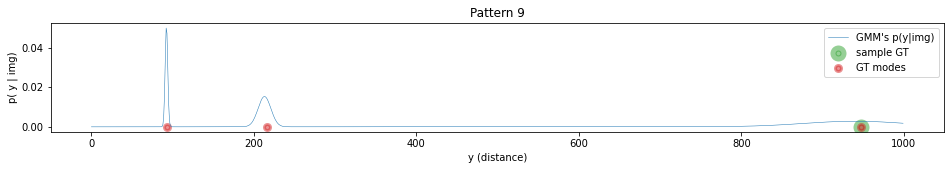

GT: [946.71807486]
Component 1: pi= 0.05 , mu= 665.68 , sig= 327.37
Component 2: pi= 0.2 , mu= 92.37 , sig= 1.58
Component 3: pi= 0.3 , mu= 213.03 , sig= 7.85
Component 4: pi= 0.44 , mu= 939.94 , sig= 62.6
Component 5: pi= 0.0 , mu= 541.37 , sig= 22.38
Component 6: pi= 0.0 , mu= 43.47 , sig= 0.0


In [221]:
ind = np.random.randint(50)
pattern_ID = 0
for i in range(10):
    pattern_ID = i
    visualise_probability_for_datapoint(model_MDN, x_train, y_train, pattern_ids_train, num_comp, pattern_ID=pattern_ID, num_points=1, ind=ind, fixed_variance=False)

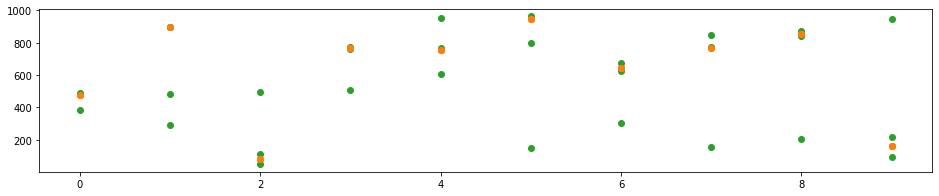

In [125]:
visualise_modes(model_MDN, x_train, y_train, pattern_ids_train, modes_train, num_modes, 1)

# MDN model - MDN + RWTA loss

In [28]:
# get model
num_comp = 3
output_shape = 1
model_MDN_RWTA = mdn_model(resnet_18, num_comp=num_comp, output_shape=output_shape, input_shape=(224,224,1))    

In [39]:
# compile
eps = 0.001

adam = keras.optimizers.Adam(0.0001)
model_MDN_RWTA.compile(optimizer=adam, 
                  loss=get_MDN_RWTA_loss(num_comp, eps, output_shape, fixed_variance=False), 
                  metrics=trace_max_component(num_comp, 10))

In [51]:
# train the model
history = model_MDN_RWTA.fit(x_train, y_train, batch_size=32, epochs=20)
# history_var_on = model_MDN_RWTA.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/20
22/22 [==============================] - 1s 52ms/step - loss: 41.2681 - max_mixture: 0.6321
Epoch 2/20
22/22 [==============================] - 1s 49ms/step - loss: 38.3383 - max_mixture: 0.6230
Epoch 3/20
22/22 [==============================] - 1s 49ms/step - loss: 37.6018 - max_mixture: 0.6286
Epoch 4/20
22/22 [==============================] - 1s 48ms/step - loss: 36.0416 - max_mixture: 0.6387
Epoch 5/20
22/22 [==============================] - 1s 51ms/step - loss: 34.8107 - max_mixture: 0.6219
Epoch 6/20
22/22 [==============================] - 1s 50ms/step - loss: 34.1043 - max_mixture: 0.6141
Epoch 7/20
22/22 [==============================] - 1s 47ms/step - loss: 33.3922 - max_mixture: 0.6534
Epoch 8/20
22/22 [==============================] - 1s 48ms/step - loss: 32.4985 - max_mixture: 0.6287
Epoch 9/20
22/22 [==============================] - 1s 51ms/step - loss: 31.9829 - max_mixture: 0.6136
Epoch 10/20
22/22 [==============================] - 1s 48ms/step - loss:

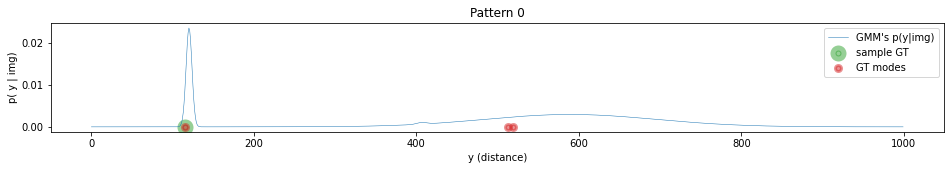

GT: [115.09527045]
Component 1: pi= 0.22 , mu= 120.17 , sig= 3.64
Component 2: pi= 0.78 , mu= 589.34 , sig= 105.23
Component 3: pi= 0.01 , mu= 406.56 , sig= 6.07


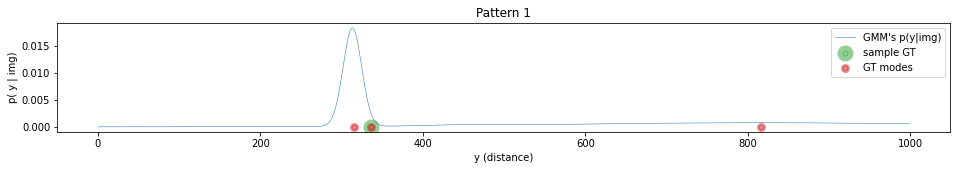

GT: [335.69555045]
Component 1: pi= 0.52 , mu= 313.39 , sig= 11.39
Component 2: pi= 0.46 , mu= 814.46 , sig= 242.42
Component 3: pi= 0.02 , mu= 450.37 , sig= 36.14


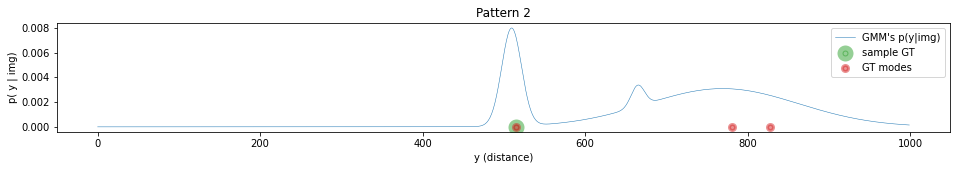

GT: [514.92877178]
Component 1: pi= 0.24 , mu= 509.52 , sig= 12.16
Component 2: pi= 0.72 , mu= 769.21 , sig= 93.38
Component 3: pi= 0.04 , mu= 664.76 , sig= 8.27


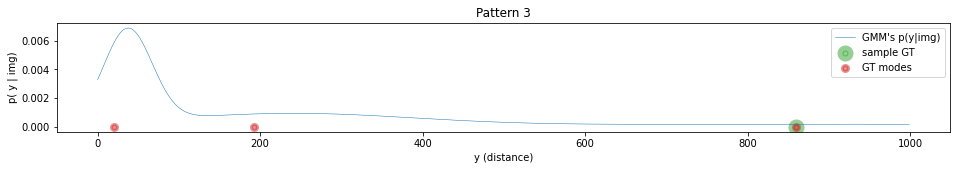

GT: [859.70345407]
Component 1: pi= 0.49 , mu= 37.12 , sig= 29.92
Component 2: pi= 0.17 , mu= 860.5 , sig= 352.08
Component 3: pi= 0.35 , mu= 235.63 , sig= 153.56


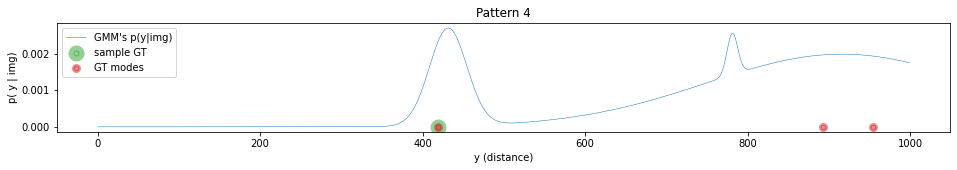

GT: [419.40847484]
Component 1: pi= 0.15 , mu= 431.43 , sig= 22.99
Component 2: pi= 0.83 , mu= 916.04 , sig= 165.65
Component 3: pi= 0.02 , mu= 781.24 , sig= 6.57


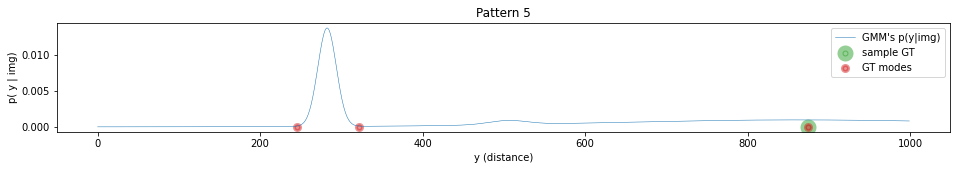

GT: [873.82364825]
Component 1: pi= 0.39 , mu= 282.42 , sig= 11.37
Component 2: pi= 0.58 , mu= 861.45 , sig= 237.88
Component 3: pi= 0.03 , mu= 505.18 , sig= 24.04


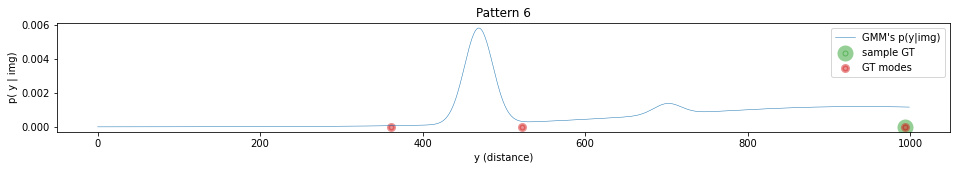

GT: [993.56896823]
Component 1: pi= 0.25 , mu= 469.0 , sig= 17.42
Component 2: pi= 0.73 , mu= 940.72 , sig= 241.97
Component 3: pi= 0.03 , mu= 701.2 , sig= 17.16


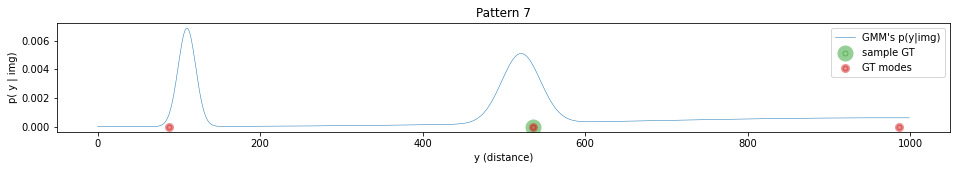

GT: [535.98150852]
Component 1: pi= 0.19 , mu= 109.91 , sig= 10.82
Component 2: pi= 0.52 , mu= 972.15 , sig= 332.62
Component 3: pi= 0.29 , mu= 521.1 , sig= 23.84


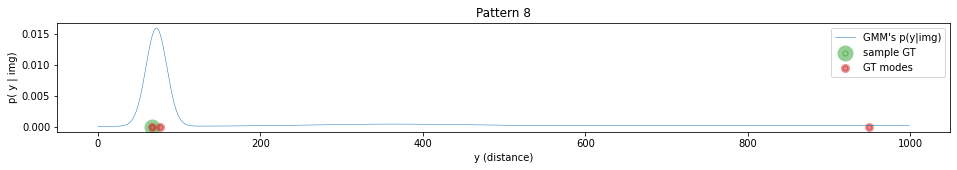

GT: [66.576382]
Component 1: pi= 0.51 , mu= 72.16 , sig= 12.8
Component 2: pi= 0.43 , mu= 963.95 , sig= 653.38
Component 3: pi= 0.06 , mu= 356.58 , sig= 84.16


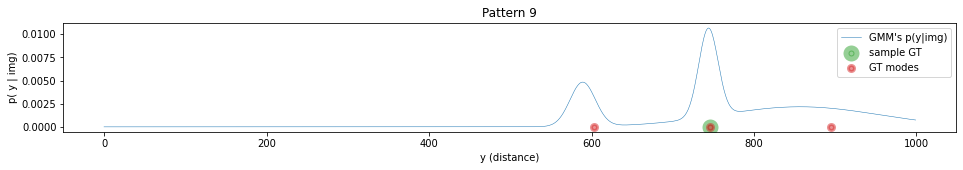

GT: [746.37862349]
Component 1: pi= 0.19 , mu= 589.1 , sig= 15.54
Component 2: pi= 0.53 , mu= 856.65 , sig= 97.11
Component 3: pi= 0.29 , mu= 743.89 , sig= 11.93


In [52]:
ind = np.random.randint(50)
pattern_ID = 0
for i in range(10):
    pattern_ID = i
    visualise_probability_for_datapoint(model_MDN_RWTA, x_train, y_train, pattern_ids_train, num_comp, pattern_ID=pattern_ID, num_points=1, ind=ind, fixed_variance=False)

In [99]:
evaluate_GMM_log_likelihood(model_MDN_RWTA, x_train, y_train)

Log likelihood: -226.49


-226.49

# MDN model - CE + RWTA
CE (cross-entropy) - is used with NLL to train weights for each mixture
RWTA - is used to train mu(x) and sigma(x) of each gaussian component of a mixture

In [15]:
# get model
num_comp = 3
output_dim = 1
model_CE_RWTA = mdn_model(resnet_18, num_comp=num_comp, output_shape=output_dim, input_shape=(224,224,1))    

In [38]:
# compile
eps = 0.001

adam = keras.optimizers.Adam(0.0001)
model_CE_RWTA.compile(optimizer=adam, 
                  loss=get_CE_RWTA_loss(num_comp, eps, output_dim, fixed_variance=False), 
                  metrics=trace_max_component(num_comp, 10))

In [39]:
# train the model
history = model_CE_RWTA.fit(x_train, y_train, batch_size=32, epochs=20)
# history_var_on = model_CE_RWTA.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/20
22/22 [==============================] - 1s 50ms/step - loss: 385.0863 - max_mixture: 0.5428
Epoch 2/20
22/22 [==============================] - 1s 48ms/step - loss: 72.3079 - max_mixture: 0.5146
Epoch 3/20
22/22 [==============================] - 1s 48ms/step - loss: 56.8639 - max_mixture: 0.5271
Epoch 4/20
22/22 [==============================] - 1s 48ms/step - loss: 33.7240 - max_mixture: 0.5203
Epoch 5/20
22/22 [==============================] - 1s 50ms/step - loss: 30.1948 - max_mixture: 0.5413
Epoch 6/20
22/22 [==============================] - 1s 48ms/step - loss: 27.8602 - max_mixture: 0.5243
Epoch 7/20
22/22 [==============================] - 1s 47ms/step - loss: 27.7491 - max_mixture: 0.5561
Epoch 8/20
22/22 [==============================] - 1s 48ms/step - loss: 23.2001 - max_mixture: 0.5483
Epoch 9/20
22/22 [==============================] - 1s 51ms/step - loss: 20.9803 - max_mixture: 0.5529
Epoch 10/20
22/22 [==============================] - 1s 48ms/step - loss

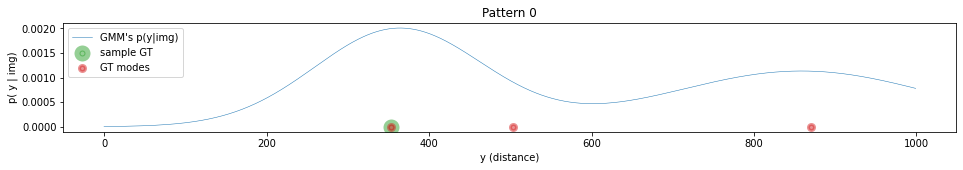

GT: [352.63241593]
Component 1: pi= 0.52 , mu= 363.13 , sig= 103.94
Component 2: pi= 0.02 , mu= 508.12 , sig= 3927.68
Component 3: pi= 0.46 , mu= 858.49 , sig= 162.62


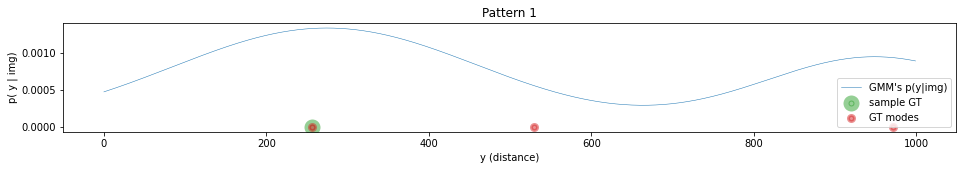

GT: [256.10758793]
Component 1: pi= 0.64 , mu= 274.39 , sig= 190.34
Component 2: pi= 0.02 , mu= 528.13 , sig= 16819.63
Component 3: pi= 0.34 , mu= 949.44 , sig= 142.42


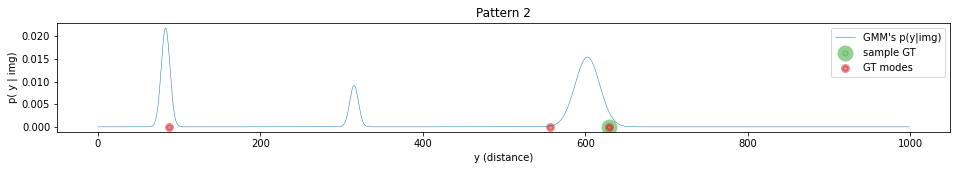

GT: [629.53267462]
Component 1: pi= 0.59 , mu= 602.65 , sig= 15.16
Component 2: pi= 0.12 , mu= 315.45 , sig= 5.29
Component 3: pi= 0.29 , mu= 83.49 , sig= 5.35


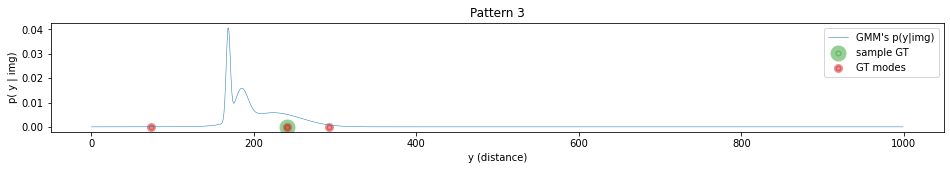

GT: [240.91103117]
Component 1: pi= 0.26 , mu= 184.65 , sig= 8.13
Component 2: pi= 0.5 , mu= 223.44 , sig= 34.55
Component 3: pi= 0.24 , mu= 168.42 , sig= 2.49


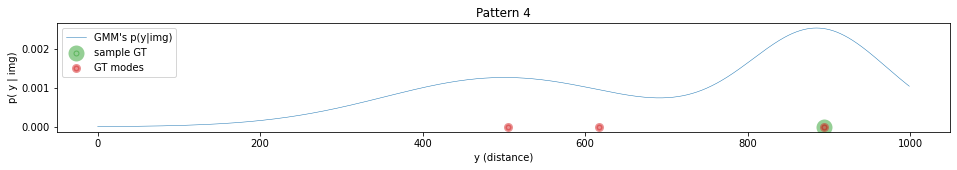

GT: [894.45480186]
Component 1: pi= 0.51 , mu= 887.32 , sig= 84.14
Component 2: pi= 0.08 , mu= 596.73 , sig= 216.24
Component 3: pi= 0.4 , mu= 495.4 , sig= 143.01


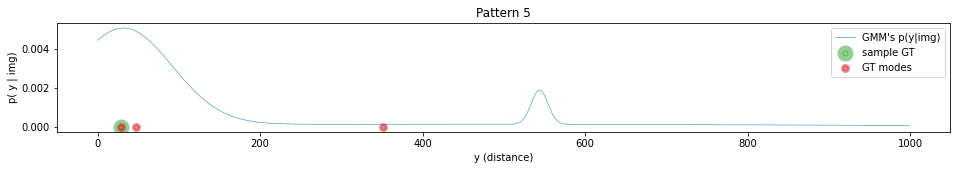

GT: [29.33226629]
Component 1: pi= 0.75 , mu= 31.54 , sig= 60.11
Component 2: pi= 0.21 , mu= 337.95 , sig= 616.89
Component 3: pi= 0.05 , mu= 543.95 , sig= 10.28


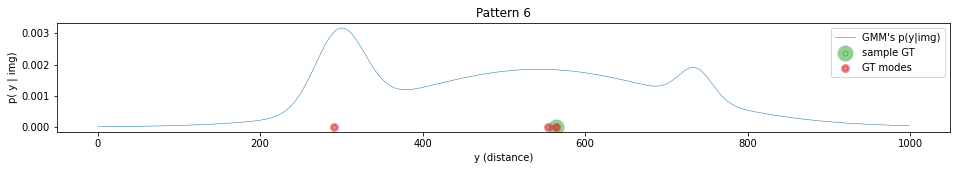

GT: [563.89863582]
Component 1: pi= 0.05 , mu= 735.81 , sig= 20.68
Component 2: pi= 0.75 , mu= 542.71 , sig= 162.51
Component 3: pi= 0.2 , mu= 298.57 , sig= 30.52


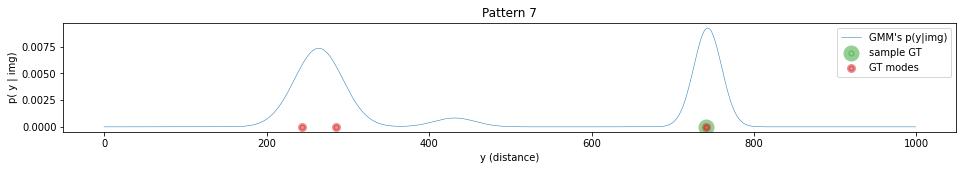

GT: [740.47531225]
Component 1: pi= 0.4 , mu= 743.03 , sig= 17.17
Component 2: pi= 0.05 , mu= 431.57 , sig= 25.44
Component 3: pi= 0.55 , mu= 264.22 , sig= 29.72


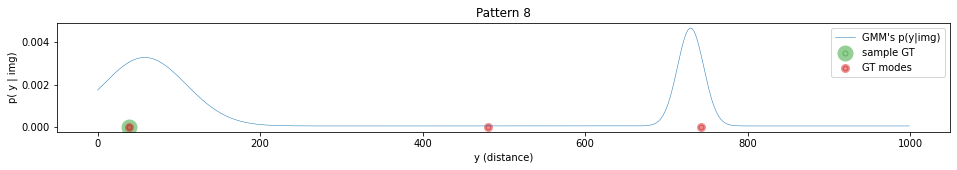

GT: [39.03006879]
Component 1: pi= 0.41 , mu= 57.97 , sig= 51.03
Component 2: pi= 0.4 , mu= 460.86 , sig= 3705.16
Component 3: pi= 0.19 , mu= 729.83 , sig= 16.08


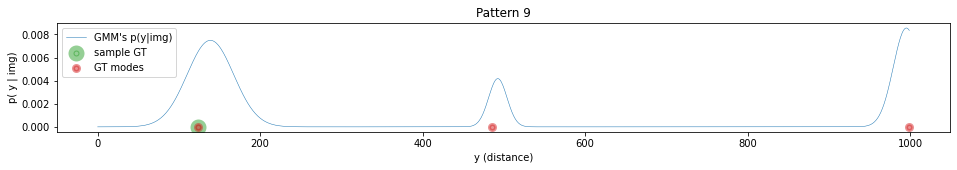

GT: [122.91162667]
Component 1: pi= 0.34 , mu= 995.39 , sig= 16.06
Component 2: pi= 0.12 , mu= 492.54 , sig= 11.31
Component 3: pi= 0.54 , mu= 138.75 , sig= 28.59


In [40]:
ind = np.random.randint(50)
pattern_ID = 0
for i in range(10):
    pattern_ID = i
    visualise_probability_for_datapoint(model_CE_RWTA, x_train, y_train, pattern_ids_train, num_comp, pattern_ID=pattern_ID, num_points=1, ind=ind, fixed_variance=False)

### you may want to switch to L-1 metric for choosing MDN branch for loss optimisation. as the original papers says it performed better than the probability based decision making.

# Callbacks to track model training

### Calback for log likelihood

In [102]:
"""
This callbacks are mainly created to make for metrics
such that I can compare models with different loss functions to each other, while they are being trained.
"""
import tensorflow as tf
from tensorflow import keras
import numpy as np

from general_utilis import get_mixture_dist


class model_log_likelihood_callback(keras.callbacks.Callback):
    def __init__(self, model_name, x, y, num_comp, fixed_variance): 
        super(model_log_likelihood_callback, self).__init__()
        
        # experiment dir
        self.exp_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/debugging/2D_set_of_explenations/experiments"

        # store data to print at the end
        self.log_likelihood = []
        
        # store data
        self.model_name = model_name
        self.x = x
        self.y = y
        self.num_comp = num_comp
        self.fixed_variance = fixed_variance
        
        self.num_datapoints = len(x)
        self.output_dim = y.shape[-1]

        # tensorboard writer
        self.writer = tf.summary.create_file_writer(self.exp_dir + '/logs/' + model_name + "_log_likelihood")
        self.step_number = 0
        

    def get_metric(self):
        return self.log_likelihood
        
    def load_data(self, data_filename):
        data = np.load(data_filename)
        return data
        
    def on_epoch_begin(self, epoch, logs=None):
        
        # get predictions
        y_pred = self.model.predict(self.x)

        # split into GMM parameters
        mix_comp_logits = y_pred[:, :self.num_comp]
        mus = y_pred[:, self.num_comp:(1+self.output_dim)*self.num_comp]
        sigmas = y_pred[:, (1+self.output_dim)*self.num_comp:]
        if fixed_variance:
            sigmas = np.ones(sigmas.shape)

        # convert logits to categorical distribution - need to itterate through all points
        mix_comp = np.zeros((self.num_datapoints, self.num_comp))
        for i in range(self.num_datapoints):
            mix_comp[i,:] = get_mixture_dist(mix_comp_logits[i,:], self.num_comp)
        
        # get log likelihood
        log_likelihood = 0
        for i in range(self.num_comp):
            for j in range(self.output_dim):
                mse = -0.5*np.sum(mix_comp[:,i]*np.square((self.y[:,j]-mus[:,(i*self.output_dim)+j])/(sigmas[:,(i*self.output_dim)+j]+1e-9)))
                sigma_trace = -np.sum((mix_comp[:,i]+1e-9)*np.log(sigmas[:,(i*self.output_dim)+j]+1e-7))
                log2pi = -np.sum(mix_comp[:,i]*0.5*self.output_dim*np.log(2*np.pi))
                log_likelihood += mse + sigma_trace + log2pi

        avg_log_likelihood = np.round(log_likelihood / self.num_datapoints, 2)
        self.log_likelihood.append(avg_log_likelihood)
        
        print(f'{self.model_name} avg. Log likelihood: {avg_log_likelihood}')
        
        
        
        # save to tensorboard
        with self.writer.as_default():
            tf.summary.scalar('avg_log_likelihood', avg_log_likelihood, step=self.step_number, description=None)
        self.step_number += 1
        
        
        
class L1_distance_callback(keras.callbacks.Callback):
    """
    This metric measures distance of a sample to the closest predicted mode mean.
    """
    def __init__(self, model_name, x, y, num_comp): 
        super(L1_distance_callback, self).__init__()
        
        # experiment directory
        self.exp_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/debugging/2D_set_of_explenations/experiments"
        
        # store data to print at the end
        self.L1_distance = []
        
        # store data
        self.model_name = model_name
        self.x = x
        self.y = y
        self.num_comp = num_comp
        self.num_datapoints = len(x)
        self.output_dim = y.shape[-1]

        # tensorboard writer
        self.writer = tf.summary.create_file_writer(self.exp_dir + '/logs/' + model_name + "_L1_distance")
        self.step_number = 0
        

    def get_metric(self):
        return self.L1_distance
        
    def load_data(self, data_filename):
        data = np.load(data_filename)
        return data
        
    def on_epoch_begin(self, epoch, logs=None):
        
        # get predictions
        y_pred = self.model.predict(self.x)
        
        if model_name == 'rwta':
            """ this is MSE based network with 'num_comp' seperate heads, 
            so not MDN based and needs a different output processing to obtain the metric. """
            l1_distances = np.abs(self.y - y_pred)
        else:
            # split into GMM parameters
            mix_comp_logits = y_pred[:, :self.num_comp]
            mus = y_pred[:, self.num_comp:(1+self.output_dim)*self.num_comp]
            sigmas = y_pred[:, (1+self.output_dim)*self.num_comp:]

            # convert logits to categorical distribution - need to itterate through all points
            mix_comp = np.zeros((self.num_datapoints, self.num_comp))
            for i in range(self.num_datapoints):
                mix_comp[i,:] = get_mixture_dist(mix_comp_logits[i,:], self.num_comp)
            
            # compute l1 distance with each mixture
            l1_distances = np.abs(self.y - mus)

            # make sure that only heads/mix. components with probability greater than 0.1 are considered
            l1_distances = np.where(mix_comp < 0.1, 1e9, l1_distances)

        l1_distances = np.min(l1_distances, axis=1)
        avg_l1_distance = np.mean(l1_distances)
        
        self.L1_distance.append(avg_l1_distance)
        
        print(f'{self.model_name} avg. L1 distance to the best (oracle) mode: {avg_l1_distance}')
              
        # save to tensorboard
        with self.writer.as_default():
            tf.summary.scalar('avg_L1_distance', avg_l1_distance, step=self.step_number, description=None)
        self.step_number += 1

In [156]:
class track_mixture_weights(keras.callbacks.Callback):
    """
    This metric allows to track how models decided to weight mixture components per pattern.
    Because we know that division of datapoints associated with each pattern are split ivenly across modes,
    we know that ideal model should have equal mixture components => each=0.33
    
    So this metric allows to track whether a mode colapse happens.
    """
    def __init__(self, model_name, x, y, pattern_ids, modes, num_comp, num_epochs): 
        super(track_mixture_weights, self).__init__()
        
        # experiment directory
        self.exp_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/debugging/2D_set_of_explenations/experiments"
        
        # store data to print at the end
        self.unique_patterns = np.unique(pattern_ids)
        # shape is (num_epochs, num_patterns, num_modes)
        self.mixture_weights_per_pattern = np.zeros((num_epochs, len(self.unique_patterns), num_comp))
        self.epoch_counter = 0
        
        # store data
        self.model_name = model_name
        self.x = x
        self.y = y
        self.pattern_ids = pattern_ids
        self.modes = modes
        self.num_comp = num_comp
        self.num_datapoints = len(x)
        self.output_dim = y.shape[-1]
        
        # for this metric we don't log to tensorboard - this metric is needed to do some cool plots after training.
        

    def get_metric(self):
        return self.mixture_weights_per_pattern
        
    def load_data(self, data_filename):
        data = np.load(data_filename)
        return data
        
    def on_epoch_end(self, epoch, logs=None):
        
        # get predictions
        y_pred = self.model.predict(self.x)

        # split into GMM parameters
        mix_comp_logits = y_pred[:, :self.num_comp]
        mus = y_pred[:, self.num_comp:(1+self.output_dim)*self.num_comp]
        sigmas = y_pred[:, (1+self.output_dim)*self.num_comp:]

        # convert logits to categorical distribution - need to itterate through all points
        mix_comp = np.zeros((self.num_datapoints, self.num_comp))
        for i in range(self.num_datapoints):
            mix_comp[i,:] = get_mixture_dist(mix_comp_logits[i,:], self.num_comp)
        
        for p_id in self.unique_patterns:
            p_indexes = np.where(self.pattern_ids == p_id, 1, 0).astype(bool)

            self.mixture_weights_per_pattern[self.epoch_counter, p_id, :] = np.mean(mix_comp[p_indexes, :]+1e-9, axis=0)
        
        self.epoch_counter += 1

# Evaluate models

**Models to evaluate:**
* R-WTA
* MDN
* MDN & RWTA
* CE & RWTA

In [157]:
exp_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/debugging/2D_set_of_explenations/experiments"

def save_dict_to_json(experiment_full_name, history):
    # make directory
    if not os.path.exists(experiment_full_name):
        os.makedirs(experiment_full_name)
    
    hist_json_file = experiment_full_name + '/train_history.json' 

    with open(hist_json_file, 'w') as history_file:
        json.dump(history, history_file, sort_keys=True, indent=4)

In [ ]:
num_comp = 3
output_dim = 1
eps = 0.001
fixed_variance = True
LR = 0.001
num_epochs = 400


models = {'rwta': {'loss': get_RWTA_for_MSE_loss},
          'mdn': {'loss': get_mdn_loss},
          'mdn_rwta': {'loss': get_MDN_RWTA_loss},
          'ce_rwta': {'loss': get_CE_RWTA_loss}}


for model_name, model_dict in models.items():
    print()
    print(f'Now training: {model_name}')
    
    # get model
    if model_name == 'rwta':
        model = basic_model(resnet_18, num_heads=num_comp, output_dim=output_dim, input_shape=(224,224,1))
        callbacks = [L1_distance_callback(model_name, x_train, y_train, num_comp)]
    else:
        model = mdn_model(resnet_18, num_comp=num_comp, output_shape=output_dim, input_shape=(224,224,1))
        callbacks = [model_log_likelihood_callback(model_name, x_train, y_train, num_comp, fixed_variance=True),
                    L1_distance_callback(model_name, x_train, y_train, num_comp),
                    track_mixture_weights(model_name, x_train, y_train, pattern_ids_train, modes_train, num_comp, num_epochs)]
    

    # train for 400 epochs at LR= 0.001  - variances OFF
    adam = keras.optimizers.Adam(0.001)
    model.compile(optimizer=adam, 
                      loss=model_dict['loss'](num_comp, eps, output_dim, fixed_variance=True), 
                      metrics=trace_max_component(num_comp, 10))
    history = model.fit(x_train, y_train, batch_size=32, epochs=num_epochs, callbacks=callbacks)
    
    
    # save data from the model
    models[model_name]['history'] = [history]
    models[model_name]['model'] = model
    
    if model_name == 'rwta':
        models[model_name]['avg_log_likelihood'] = None
        models[model_name]['avg_L1_distance'] = callbacks[0].get_metric()
        models[model_name]['mixture_weights_distribution'] = None
    else:
        models[model_name]['avg_log_likelihood'] = callbacks[0].get_metric()
        models[model_name]['avg_L1_distance'] = callbacks[1].get_metric()
        models[model_name]['mixture_weights_distribution'] = callbacks[2].get_metric()

        
    
    # save history to file
    save_dir_name = exp_dir + '/' + model_name
    save_dict_to_json(save_dir_name, history.history) 
    
    # save metrics to file
    np.save(save_dir_name + '/avg_log_likelihood.npy', models[model_name]['avg_log_likelihood'])
    np.save(save_dir_name + '/avg_L1_distance.npy', models[model_name]['avg_L1_distance'])  
    np.save(save_dir_name + '/mixture_weights_distribution.npy', models[model_name]['mixture_weights_distribution'])  

    
    # save models to be read again if needed
#     model.save(save_dir_name + '/saved_model')
        

# we may want to wit with running variances just so we don't destroy our models.
# then we can run training with trainable variances and see where we get - when variances are on the training is unstable.
    
#     # train for 40 epochs at LR= 0.0001   - variances ON
#     adam = keras.optimizers.Adam(0.0001)
#     model.compile(optimizer=adam, 
#                       loss=model_dict['loss'](num_comp, eps, output_dim, fixed_variance=False), 
#                       metrics=trace_max_component(num_comp, 10))
#     history = model.fit(x_train, y_train, batch_size=32, epochs=1, callbacks=callbacks)
#     models[model_name]['history'].append(history)
#     models[model_name]['model'] = model
#     if model_name == 'rwta':
#         models[model_name]['avg_log_likelihood'] = None
#     else:
#         models[model_name]['avg_log_likelihood'].append([callbacks[0].get_metric()])



Now training: rwta
rwta avg. L1 distance to the best (oracle) mode: 153.39817967495327
Epoch 1/400
22/22 [==============================] - 1s 45ms/step - loss: 839863.6875 - max_mixture: 0.9653
rwta avg. L1 distance to the best (oracle) mode: 173.3061361043725
Epoch 2/400
22/22 [==============================] - 1s 45ms/step - loss: 757015.3125 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 75.40692481893136
Epoch 3/400
22/22 [==============================] - 1s 44ms/step - loss: 636042.3125 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 171.158707523278
Epoch 4/400
22/22 [==============================] - 1s 43ms/step - loss: 492958.2188 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 172.83179841782075
Epoch 5/400
22/22 [==============================] - 1s 44ms/step - loss: 348622.4688 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 166.00057249794585
Epoch 6/400
22/22 [=================

22/22 [==============================] - 1s 45ms/step - loss: 8882.1953 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 45.67202259790517
Epoch 48/400
22/22 [==============================] - 1s 44ms/step - loss: 9073.0625 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 51.2409350436189
Epoch 49/400
22/22 [==============================] - 1s 44ms/step - loss: 9669.1562 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 45.352324740369184
Epoch 50/400
22/22 [==============================] - 1s 45ms/step - loss: 8935.2500 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 42.58290766394764
Epoch 51/400
22/22 [==============================] - 1s 43ms/step - loss: 8767.3643 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 45.66803820457965
Epoch 52/400
22/22 [==============================] - 1s 44ms/step - loss: 8918.5586 - max_mixture: 1.0000
rwta avg. L1 distance to the best (o

22/22 [==============================] - 1s 44ms/step - loss: 5185.8452 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 28.038018607504316
Epoch 95/400
22/22 [==============================] - 1s 44ms/step - loss: 5202.2109 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 30.14668454517242
Epoch 96/400
22/22 [==============================] - 1s 44ms/step - loss: 5017.2539 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 26.624493490695844
Epoch 97/400
22/22 [==============================] - 1s 44ms/step - loss: 5096.7051 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 28.420475710595316
Epoch 98/400
22/22 [==============================] - 1s 44ms/step - loss: 4902.6641 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 32.94536602608771
Epoch 99/400
22/22 [==============================] - 1s 44ms/step - loss: 4802.5352 - max_mixture: 1.0000
rwta avg. L1 distance to the best

22/22 [==============================] - 1s 45ms/step - loss: 4735.5337 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.701526837576864
Epoch 142/400
22/22 [==============================] - 1s 43ms/step - loss: 4708.2520 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.507174826400234
Epoch 143/400
22/22 [==============================] - 1s 44ms/step - loss: 4615.2803 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 27.270167460434024
Epoch 144/400
22/22 [==============================] - 1s 44ms/step - loss: 4568.0005 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 27.242096076989483
Epoch 145/400
22/22 [==============================] - 1s 43ms/step - loss: 4534.9263 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 27.004678855094223
Epoch 146/400
22/22 [==============================] - 1s 44ms/step - loss: 4711.8066 - max_mixture: 1.0000
rwta avg. L1 distance to t

22/22 [==============================] - 1s 44ms/step - loss: 4537.4302 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.89750317172194
Epoch 189/400
22/22 [==============================] - 1s 44ms/step - loss: 4594.3223 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 27.11164339548806
Epoch 190/400
22/22 [==============================] - 1s 44ms/step - loss: 4506.8462 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.07458093698329
Epoch 191/400
22/22 [==============================] - 1s 44ms/step - loss: 4573.0576 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 23.873337293046855
Epoch 192/400
22/22 [==============================] - 1s 44ms/step - loss: 4578.2705 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.303797557714383
Epoch 193/400
22/22 [==============================] - 1s 44ms/step - loss: 4565.3433 - max_mixture: 1.0000
rwta avg. L1 distance to the 

22/22 [==============================] - 1s 45ms/step - loss: 4612.2485 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 27.2714389655587
Epoch 236/400
22/22 [==============================] - 1s 45ms/step - loss: 4531.8799 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.124433881973154
Epoch 237/400
22/22 [==============================] - 1s 45ms/step - loss: 4494.3301 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.85144025446215
Epoch 238/400
22/22 [==============================] - 1s 44ms/step - loss: 4625.4146 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 50.21946965997119
Epoch 239/400
22/22 [==============================] - 1s 44ms/step - loss: 4480.6855 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 54.20137277531183
Epoch 240/400
22/22 [==============================] - 1s 44ms/step - loss: 4488.0767 - max_mixture: 1.0000
rwta avg. L1 distance to the be

22/22 [==============================] - 1s 44ms/step - loss: 4438.7354 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.025748491875024
Epoch 283/400
22/22 [==============================] - 1s 45ms/step - loss: 4396.9482 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 23.50596883522597
Epoch 284/400
22/22 [==============================] - 1s 44ms/step - loss: 4557.3867 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 23.496749999262118
Epoch 285/400
22/22 [==============================] - 1s 43ms/step - loss: 4488.1318 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 37.897840211752516
Epoch 286/400
22/22 [==============================] - 1s 44ms/step - loss: 4559.8340 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.27324756049847
Epoch 287/400
22/22 [==============================] - 1s 44ms/step - loss: 4352.4263 - max_mixture: 1.0000
rwta avg. L1 distance to the

22/22 [==============================] - 1s 44ms/step - loss: 4500.8867 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 27.75234052341331
Epoch 330/400
22/22 [==============================] - 1s 43ms/step - loss: 4579.5938 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.28284460458361
Epoch 331/400
22/22 [==============================] - 1s 45ms/step - loss: 4527.6152 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 26.393799226561388
Epoch 332/400
22/22 [==============================] - 1s 43ms/step - loss: 4370.5508 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.324573115288658
Epoch 333/400
22/22 [==============================] - 1s 45ms/step - loss: 4378.1709 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.36064626557268
Epoch 334/400
22/22 [==============================] - 1s 45ms/step - loss: 4442.0322 - max_mixture: 1.0000
rwta avg. L1 distance to the 

22/22 [==============================] - 1s 44ms/step - loss: 4440.1582 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 54.33089685443254
Epoch 377/400
22/22 [==============================] - 1s 44ms/step - loss: 4455.2808 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 25.889578564270394
Epoch 378/400
22/22 [==============================] - 1s 44ms/step - loss: 4373.6758 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.24445824893418
Epoch 379/400
22/22 [==============================] - 1s 44ms/step - loss: 4385.2705 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 23.095735648880037
Epoch 380/400
22/22 [==============================] - 1s 45ms/step - loss: 4446.8662 - max_mixture: 1.0000
rwta avg. L1 distance to the best (oracle) mode: 24.961740784970274
Epoch 381/400
22/22 [==============================] - 1s 43ms/step - loss: 4326.7886 - max_mixture: 1.0000
rwta avg. L1 distance to the

22/22 [==============================] - 2s 110ms/step - loss: 65017.8672 - max_mixture: 0.8380
mdn avg. Log likelihood: -64861.1
mdn avg. L1 distance to the best (oracle) mode: 266.8970651548128
Epoch 20/400
22/22 [==============================] - 2s 108ms/step - loss: 60151.4414 - max_mixture: 0.8781
mdn avg. Log likelihood: -53562.5
mdn avg. L1 distance to the best (oracle) mode: 235.08600523404897
Epoch 21/400
22/22 [==============================] - 2s 107ms/step - loss: 56118.8008 - max_mixture: 0.8374
mdn avg. Log likelihood: -57610.38
mdn avg. L1 distance to the best (oracle) mode: 235.25864622330593
Epoch 22/400
22/22 [==============================] - 2s 104ms/step - loss: 51751.9375 - max_mixture: 0.8650
mdn avg. Log likelihood: -49954.04
mdn avg. L1 distance to the best (oracle) mode: 227.79368992849922
Epoch 23/400
22/22 [==============================] - 2s 106ms/step - loss: 48317.3477 - max_mixture: 0.8401
mdn avg. Log likelihood: -48531.35
mdn avg. L1 distance to the 

22/22 [==============================] - 2s 110ms/step - loss: 1726.8878 - max_mixture: 0.5593
mdn avg. Log likelihood: -65510.91
mdn avg. L1 distance to the best (oracle) mode: 54.16707168084496
Epoch 59/400
22/22 [==============================] - 2s 102ms/step - loss: 1707.5537 - max_mixture: 0.5376
mdn avg. Log likelihood: -56821.22
mdn avg. L1 distance to the best (oracle) mode: 68.54152339814613
Epoch 60/400
22/22 [==============================] - 2s 103ms/step - loss: 1360.9862 - max_mixture: 0.5486
mdn avg. Log likelihood: -62069.32
mdn avg. L1 distance to the best (oracle) mode: 48.72941037483996
Epoch 61/400
22/22 [==============================] - 2s 103ms/step - loss: 1295.5248 - max_mixture: 0.5281
mdn avg. Log likelihood: -65246.2
mdn avg. L1 distance to the best (oracle) mode: 35.87107353749579
Epoch 62/400
22/22 [==============================] - 2s 104ms/step - loss: 1224.5894 - max_mixture: 0.5665
mdn avg. Log likelihood: -65193.09
mdn avg. L1 distance to the best (o

22/22 [==============================] - 3s 118ms/step - loss: 678.3610 - max_mixture: 0.5806
mdn avg. Log likelihood: -60297.47
mdn avg. L1 distance to the best (oracle) mode: 39.88188051411141
Epoch 98/400
22/22 [==============================] - 3s 115ms/step - loss: 848.5043 - max_mixture: 0.5784
mdn avg. Log likelihood: -61515.03
mdn avg. L1 distance to the best (oracle) mode: 23.265891821724367
Epoch 99/400
22/22 [==============================] - 2s 108ms/step - loss: 970.9379 - max_mixture: 0.6004
mdn avg. Log likelihood: -63592.18
mdn avg. L1 distance to the best (oracle) mode: 37.39511712278846
Epoch 100/400
22/22 [==============================] - 2s 112ms/step - loss: 697.1544 - max_mixture: 0.5688
mdn avg. Log likelihood: -64370.75
mdn avg. L1 distance to the best (oracle) mode: 42.425489782894836
Epoch 101/400
22/22 [==============================] - 2s 110ms/step - loss: 823.3844 - max_mixture: 0.5618
mdn avg. Log likelihood: -64092.76
mdn avg. L1 distance to the best (o

22/22 [==============================] - 2s 113ms/step - loss: 721.2195 - max_mixture: 0.5731
mdn avg. Log likelihood: -65257.25
mdn avg. L1 distance to the best (oracle) mode: 13.994054585220963
Epoch 137/400
22/22 [==============================] - 3s 115ms/step - loss: 487.6358 - max_mixture: 0.5894
mdn avg. Log likelihood: -60798.49
mdn avg. L1 distance to the best (oracle) mode: 29.722950548033655
Epoch 138/400
22/22 [==============================] - 2s 114ms/step - loss: 505.7929 - max_mixture: 0.5433
mdn avg. Log likelihood: -63054.25
mdn avg. L1 distance to the best (oracle) mode: 17.13989328768464
Epoch 139/400
22/22 [==============================] - 2s 111ms/step - loss: 560.7841 - max_mixture: 0.5337
mdn avg. Log likelihood: -63124.57
mdn avg. L1 distance to the best (oracle) mode: 23.685192132856272
Epoch 140/400
22/22 [==============================] - 2s 107ms/step - loss: 546.8650 - max_mixture: 0.5458
mdn avg. Log likelihood: -65874.06
mdn avg. L1 distance to the best

22/22 [==============================] - 3s 119ms/step - loss: 500.5162 - max_mixture: 0.5494
mdn avg. Log likelihood: -59574.97
mdn avg. L1 distance to the best (oracle) mode: 36.091594477446606
Epoch 176/400
22/22 [==============================] - 2s 109ms/step - loss: 402.8114 - max_mixture: 0.5425
mdn avg. Log likelihood: -68318.61
mdn avg. L1 distance to the best (oracle) mode: 21.736229970634174
Epoch 177/400
22/22 [==============================] - 2s 113ms/step - loss: 505.0186 - max_mixture: 0.5639
mdn avg. Log likelihood: -70060.6
mdn avg. L1 distance to the best (oracle) mode: 21.107602968956893
Epoch 178/400
22/22 [==============================] - 3s 116ms/step - loss: 360.8293 - max_mixture: 0.5848
mdn avg. Log likelihood: -73329.64
mdn avg. L1 distance to the best (oracle) mode: 22.20852110417676
Epoch 179/400
22/22 [==============================] - 3s 118ms/step - loss: 453.2686 - max_mixture: 0.5456
mdn avg. Log likelihood: -64900.53
mdn avg. L1 distance to the best 

22/22 [==============================] - 3s 117ms/step - loss: 361.0565 - max_mixture: 0.5563
mdn avg. Log likelihood: -61369.17
mdn avg. L1 distance to the best (oracle) mode: 32.907427080088254
Epoch 215/400
22/22 [==============================] - 2s 112ms/step - loss: 281.9626 - max_mixture: 0.5544
mdn avg. Log likelihood: -66318.73
mdn avg. L1 distance to the best (oracle) mode: 13.40432436105618
Epoch 216/400
22/22 [==============================] - 3s 116ms/step - loss: 246.3506 - max_mixture: 0.5701
mdn avg. Log likelihood: -62089.76
mdn avg. L1 distance to the best (oracle) mode: 19.02943045744754
Epoch 217/400
22/22 [==============================] - 2s 108ms/step - loss: 282.0324 - max_mixture: 0.5523
mdn avg. Log likelihood: -67946.55
mdn avg. L1 distance to the best (oracle) mode: 11.166679873395378
Epoch 218/400
22/22 [==============================] - 3s 119ms/step - loss: 247.0363 - max_mixture: 0.5517
mdn avg. Log likelihood: -67894.82
mdn avg. L1 distance to the best 

22/22 [==============================] - 2s 113ms/step - loss: 189.5397 - max_mixture: 0.5472
mdn avg. Log likelihood: -63178.0
mdn avg. L1 distance to the best (oracle) mode: 14.445828936161842
Epoch 254/400
22/22 [==============================] - 3s 118ms/step - loss: 243.0363 - max_mixture: 0.5391
mdn avg. Log likelihood: -66562.96
mdn avg. L1 distance to the best (oracle) mode: 20.96634608119781
Epoch 255/400
22/22 [==============================] - 2s 112ms/step - loss: 260.8468 - max_mixture: 0.5414
mdn avg. Log likelihood: -67799.26
mdn avg. L1 distance to the best (oracle) mode: 15.532321460106525
Epoch 256/400
22/22 [==============================] - 2s 111ms/step - loss: 303.5941 - max_mixture: 0.5618
mdn avg. Log likelihood: -64761.02
mdn avg. L1 distance to the best (oracle) mode: 12.563723978870364
Epoch 257/400
22/22 [==============================] - 2s 113ms/step - loss: 231.2519 - max_mixture: 0.5631
mdn avg. Log likelihood: -68366.4
mdn avg. L1 distance to the best (

22/22 [==============================] - 2s 110ms/step - loss: 190.3047 - max_mixture: 0.5238
mdn avg. Log likelihood: -61516.95
mdn avg. L1 distance to the best (oracle) mode: 28.695279412495086
Epoch 293/400
22/22 [==============================] - 3s 114ms/step - loss: 161.6629 - max_mixture: 0.5420
mdn avg. Log likelihood: -61311.7
mdn avg. L1 distance to the best (oracle) mode: 9.965699267913063
Epoch 294/400
22/22 [==============================] - 3s 114ms/step - loss: 166.0709 - max_mixture: 0.5481
mdn avg. Log likelihood: -62804.48
mdn avg. L1 distance to the best (oracle) mode: 27.199815909984423
Epoch 295/400
22/22 [==============================] - 3s 115ms/step - loss: 163.4478 - max_mixture: 0.5629
mdn avg. Log likelihood: -60878.4
mdn avg. L1 distance to the best (oracle) mode: 29.20503566851251
Epoch 296/400
22/22 [==============================] - 2s 112ms/step - loss: 218.0307 - max_mixture: 0.5688
mdn avg. Log likelihood: -63420.11
mdn avg. L1 distance to the best (o

22/22 [==============================] - 3s 116ms/step - loss: 197.5715 - max_mixture: 0.5768
mdn avg. Log likelihood: -64150.88
mdn avg. L1 distance to the best (oracle) mode: 9.694587207841751
Epoch 332/400
22/22 [==============================] - 2s 113ms/step - loss: 168.7923 - max_mixture: 0.5646
mdn avg. Log likelihood: -59984.43
mdn avg. L1 distance to the best (oracle) mode: 10.800406328479479
Epoch 333/400
22/22 [==============================] - 3s 114ms/step - loss: 234.6975 - max_mixture: 0.6000
mdn avg. Log likelihood: -64384.42
mdn avg. L1 distance to the best (oracle) mode: 10.215513431307668
Epoch 334/400
22/22 [==============================] - 2s 108ms/step - loss: 191.4919 - max_mixture: 0.5528
mdn avg. Log likelihood: -68592.05
mdn avg. L1 distance to the best (oracle) mode: 12.102108914606667
Epoch 335/400
22/22 [==============================] - 3s 115ms/step - loss: 180.9639 - max_mixture: 0.5317
mdn avg. Log likelihood: -64678.98
mdn avg. L1 distance to the best

22/22 [==============================] - 3s 114ms/step - loss: 172.4158 - max_mixture: 0.5590
mdn avg. Log likelihood: -62364.19
mdn avg. L1 distance to the best (oracle) mode: 11.819543654562404
Epoch 371/400
22/22 [==============================] - 3s 114ms/step - loss: 176.0432 - max_mixture: 0.5608
mdn avg. Log likelihood: -62022.25
mdn avg. L1 distance to the best (oracle) mode: 28.68342328189442
Epoch 372/400
22/22 [==============================] - 2s 114ms/step - loss: 212.2000 - max_mixture: 0.5654
mdn avg. Log likelihood: -69816.49
mdn avg. L1 distance to the best (oracle) mode: 11.068267185546533
Epoch 373/400
22/22 [==============================] - 3s 114ms/step - loss: 206.5819 - max_mixture: 0.5621
mdn avg. Log likelihood: -62303.29
mdn avg. L1 distance to the best (oracle) mode: 17.25317519287769
Epoch 374/400
22/22 [==============================] - 3s 118ms/step - loss: 222.3507 - max_mixture: 0.5512
mdn avg. Log likelihood: -68332.93
mdn avg. L1 distance to the best 

mdn_rwta avg. L1 distance to the best (oracle) mode: 405.93846707438666
Epoch 9/400
22/22 [==============================] - 2s 109ms/step - loss: 445928.1250 - max_mixture: 0.9692
mdn_rwta avg. Log likelihood: -118555.16
mdn_rwta avg. L1 distance to the best (oracle) mode: 405.4586199051842
Epoch 10/400
22/22 [==============================] - 2s 108ms/step - loss: 425725.1562 - max_mixture: 0.9695
mdn_rwta avg. Log likelihood: -111021.34
mdn_rwta avg. L1 distance to the best (oracle) mode: 377.0667910512848
Epoch 11/400
22/22 [==============================] - 2s 107ms/step - loss: 407488.3750 - max_mixture: 0.9278
mdn_rwta avg. Log likelihood: -113560.89
mdn_rwta avg. L1 distance to the best (oracle) mode: 379.6171469932216
Epoch 12/400
22/22 [==============================] - 2s 110ms/step - loss: 388633.2188 - max_mixture: 0.9399
mdn_rwta avg. Log likelihood: -92842.51
mdn_rwta avg. L1 distance to the best (oracle) mode: 350.365382282133
Epoch 13/400
22/22 [=======================

22/22 [==============================] - 2s 112ms/step - loss: 17783.8750 - max_mixture: 0.5468
mdn_rwta avg. Log likelihood: -58026.01
mdn_rwta avg. L1 distance to the best (oracle) mode: 87.83648056255146
Epoch 47/400
22/22 [==============================] - 2s 111ms/step - loss: 18118.8672 - max_mixture: 0.5351
mdn_rwta avg. Log likelihood: -67348.21
mdn_rwta avg. L1 distance to the best (oracle) mode: 79.42528202201945
Epoch 48/400
22/22 [==============================] - 2s 110ms/step - loss: 19071.9551 - max_mixture: 0.5654
mdn_rwta avg. Log likelihood: -64103.28
mdn_rwta avg. L1 distance to the best (oracle) mode: 103.66572433387005
Epoch 49/400
22/22 [==============================] - 3s 115ms/step - loss: 14925.9629 - max_mixture: 0.5228
mdn_rwta avg. Log likelihood: -61665.98
mdn_rwta avg. L1 distance to the best (oracle) mode: 75.677527050379
Epoch 50/400
22/22 [==============================] - 2s 112ms/step - loss: 14875.3867 - max_mixture: 0.5097
mdn_rwta avg. Log likelih

22/22 [==============================] - 2s 113ms/step - loss: 3788.3906 - max_mixture: 0.5172
mdn_rwta avg. Log likelihood: -73719.54
mdn_rwta avg. L1 distance to the best (oracle) mode: 33.563041747802025
Epoch 84/400
22/22 [==============================] - 2s 112ms/step - loss: 3439.5361 - max_mixture: 0.5495
mdn_rwta avg. Log likelihood: -84658.71
mdn_rwta avg. L1 distance to the best (oracle) mode: 30.529796679420198
Epoch 85/400
22/22 [==============================] - 3s 114ms/step - loss: 3607.9453 - max_mixture: 0.5784
mdn_rwta avg. Log likelihood: -67048.27
mdn_rwta avg. L1 distance to the best (oracle) mode: 140.15453378242532
Epoch 86/400
22/22 [==============================] - 2s 110ms/step - loss: 3362.8799 - max_mixture: 0.5671
mdn_rwta avg. Log likelihood: -77369.76
mdn_rwta avg. L1 distance to the best (oracle) mode: 26.707054857290178
Epoch 87/400
22/22 [==============================] - 3s 115ms/step - loss: 3988.7292 - max_mixture: 0.5387
mdn_rwta avg. Log likelih

22/22 [==============================] - 2s 111ms/step - loss: 2440.9897 - max_mixture: 0.5322
mdn_rwta avg. Log likelihood: -65993.77
mdn_rwta avg. L1 distance to the best (oracle) mode: 45.37208261675032
Epoch 121/400
22/22 [==============================] - 2s 111ms/step - loss: 1203.9054 - max_mixture: 0.5300
mdn_rwta avg. Log likelihood: -67604.6
mdn_rwta avg. L1 distance to the best (oracle) mode: 19.04367766784212
Epoch 122/400
22/22 [==============================] - 2s 106ms/step - loss: 2669.3726 - max_mixture: 0.5246
mdn_rwta avg. Log likelihood: -62747.86
mdn_rwta avg. L1 distance to the best (oracle) mode: 65.69099353794088
Epoch 123/400
22/22 [==============================] - 3s 117ms/step - loss: 2212.1536 - max_mixture: 0.5157
mdn_rwta avg. Log likelihood: -66332.05
mdn_rwta avg. L1 distance to the best (oracle) mode: 23.185384233823218
Epoch 124/400
22/22 [==============================] - 2s 112ms/step - loss: 2418.2078 - max_mixture: 0.5255
mdn_rwta avg. Log likelih

22/22 [==============================] - 2s 111ms/step - loss: 1424.1471 - max_mixture: 0.5228
mdn_rwta avg. Log likelihood: -74679.51
mdn_rwta avg. L1 distance to the best (oracle) mode: 25.615018232479684
Epoch 158/400
22/22 [==============================] - 2s 110ms/step - loss: 1426.5240 - max_mixture: 0.5229
mdn_rwta avg. Log likelihood: -68798.76
mdn_rwta avg. L1 distance to the best (oracle) mode: 19.087445968399656
Epoch 159/400
22/22 [==============================] - 3s 116ms/step - loss: 1398.9038 - max_mixture: 0.5384
mdn_rwta avg. Log likelihood: -66688.16
mdn_rwta avg. L1 distance to the best (oracle) mode: 23.10872096834666
Epoch 160/400
22/22 [==============================] - 2s 114ms/step - loss: 1242.7977 - max_mixture: 0.5182
mdn_rwta avg. Log likelihood: -74016.09
mdn_rwta avg. L1 distance to the best (oracle) mode: 18.24123039168814
Epoch 161/400
22/22 [==============================] - 2s 108ms/step - loss: 2223.8284 - max_mixture: 0.5391
mdn_rwta avg. Log likel

### 0. Compare learning rate convergence
Would be good to have some callback which can evaluate negative log likelihood every few epochs or so, to track a common metric across all models to see how their convergence compares.

### 1. plot posterior distribution $p(y|x=x_{sample})$  - qualitative comparison between models

In [ ]:
# get list of models
models_list = []
for model_name in models:
    if model_name != 'rwta':
        models_list.append([model_name, models[model_name]['model']])

        
# visualise predicted posterior probability
ind = np.random.randint(50)
pattern_ID = 0
for i in range(10):
    pattern_ID = i
    visualise_probability_for_datapoint(models_list, x_train, y_train, pattern_ids_train, num_comp, pattern_ID=pattern_ID, num_points=1, ind=ind, fixed_variance=True)

### 2. evaluate log likelihood for different models - which one is the best?

In [ ]:
models_result = {} 
for name, model in models.items():
    log_likelihood = evaluate_GMM_log_likelihood(model_MDN_RWTA, x_train, y_train)
    models_results[name] = {'log_likelihood': log_likelihood}

### 3. compute distribution entropy - which model is most uncertaint (the higher the more uncertain, low indicates mode colapse) - higher entropy indicates better prediction diversity

### 4. compare SEMD of models

### some variables to investigate:
* number of mixture components (the same number as GT, less, more - what happens?)

In [35]:
# need a function that can visualise predictions of the MDN model
def get_mode_means_for_X_COORD(model, x, y, num_comp, output_shape, compare):
    y_dist = model.predict(x)
    
    gaus_comp = y_dist[:,:num_comp]
    means = y_dist[:,num_comp:(output_shape+1)*num_comp]
    variances = y_dist[:,(output_shape+1)*num_comp:]
    
    mode_mean = np.zeros((y_dist.shape[0]))
    for j in range(len(x)):
        if num_comp >1:
            mixture_dist = get_mixture_dist(gaus_comp[j,:], num_comp) 
        else:
            mixture_dist = 1
        means_x = means[j,:]
        mode_mean[j] = np.dot(mixture_dist, means_x)

        print(f'GT: {np.round(y[j],2)}') #',   Pred: {np.round(mode_mean[j], 2)}')
#         print(f'lower bound:  {np.round(mode_mean[j]-mode_var[j],2)},   upper bound: {np.round(mode_mean[j]+mode_var[j],2)}')
        print(f'prd mix components: {mixture_dist}')
        print(f'prd means: {means[j]}')
        print(f'pred var: {variances[j]}')
        print()
    
    return mode_mean


In [54]:
mode_means = get_mode_means_for_X_COORD(model_MDN, x_train[:10], y_train[:10], num_comp, 1, compare=True)

GT: [496.16]
prd mix components: [0.002  0.0205 0.9775]
prd means: [233.71793 136.84425 497.46725]
pred var: [23.94206  32.394592  4.76361 ]

GT: [60.11]
prd mix components: [0.9986 0.0008 0.0006]
prd means: [ 64.206566 194.5998   643.497   ]
pred var: [ 2.6513455 46.784756  28.183924 ]

GT: [149.96]
prd mix components: [0.0005 0.9977 0.0018]
prd means: [508.4638  150.71896 664.147  ]
pred var: [22.011208   3.5202203 17.73889  ]

GT: [241.25]
prd mix components: [0.0085 0.9182 0.0733]
prd means: [188.9023  242.64659 732.829  ]
pred var: [28.570454   3.9311595  9.307612 ]

GT: [918.71]
prd mix components: [0.6315 0.0003 0.3682]
prd means: [916.9691  157.35204 874.6677 ]
pred var: [ 8.49213    3.2332115 11.04581  ]

GT: [496.16]
prd mix components: [0.0002 0.0084 0.9914]
prd means: [278.00772 133.24611 499.0411 ]
pred var: [26.940407 26.004368  4.311767]

GT: [864.6]
prd mix components: [0.3517 0.001  0.6473]
prd means: [905.60474 157.55096 860.71094]
pred var: [8.627409  3.2006042 9.287

In [ ]:
def get_predictions_MDN(model, x):
    y_dist = model.predict(x)
    
    gaus_comp = y_dist[:,:num_comp]
    means = y_dist[:,num_comp:(output_shape+1)*num_comp]
    variances = y_dist[:,(output_shape+1)*num_comp:]
    
#     mode_mean = np.zeros(len(x))
    mixture_dist = np.zeros((len(x), 3))
    
    for j in range(len(x)):
#         if num_comp >1:
        mixture_dist[j] = get_mixture_dist(gaus_comp[j,:], num_comp) 
#         else:
#             mixture_dist = 1
#         means_x = means[j,:]
#         mode_mean[j] = np.dot(mixture_dist, means_x)
        
    mix, mean, var = mixture_dist, means, variances
    return mix, mean, var

def print_error_per_mode_MDN(model, x, y, pattern_ids, modes, pattern_ID, num_modes, num_heads):
       
    pattern_indexes = np.where(pattern_ids == pattern_ID, 1, 0)
    
    for i in range(num_modes):
        mode_indexes = np.where(modes == i, 1, 0)
        mode_pat_indexes = pattern_indexes*mode_indexes
        mode_pat_indexes = mode_pat_indexes.astype(bool)

        x_tmp = x[mode_pat_indexes]
        y_tmp = y[mode_pat_indexes]
        mix, mean, var = get_predictions_MDN(model, x_tmp)
        
        print(f'MODE: {i}')
        for j in range(5):
            print(f'GT: {np.round(y_tmp[j],2)},  mix: {np.round(mix[j],2)},   means: {np.round(mean[j],2)},   var: {np.round(var[j],2)}')
        print()
        

print_error_per_mode_MDN(model_MDN, x_train, y_train, pattern_ids_train, modes_train, 0, num_modes, num_heads=1)